#Crime Data of San Francisco

DTSA 5509 Final - Introduction to Machine Learning: Supervised Learning


Steps:

1. Description of the supervised learning problem
2. Exploratory Data Analysis
3. Model analysis: building and training the model
4. Results
5. Discussion and conclusion

###Step 1: Description of the supervised learning problem

Because crime is an ongoing and significant issue in cities, my project aims to provide insight on the realities of crime statistics. News and crime reporting in the media may impress a false narrative, so my goal is to balance out the fear with data.  

The supervised learning aspect focuses on using patterns in the dataset to build a model that anyone can use to stay more informed. The most successful model in my project is one that sheds light on crime at different altitudes/elevations.

###Step 2: Exploratory Data Analysis
In this step, the goals include: acquiring and storing the data, exploring initial questions, seeing if data could provide insight.

The actions include deleting data appropriately, adding more data, and transforming data to create a more useful dataset.

#### Data Acquisition

SFPD provides a free dataset of crime reports dating back to 2018 from https://data.sfgov.org/Public-Safety/Police-Department-Incident-Reports-2018-to-Present/wg3w-h783/data_preview

Downloaded data as csv file, stored locally.

In [ ]:
# Import all necessary libraries
import scipy as sp
import scipy.stats as stats
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import math
from dateutil import parser
import requests
import time

sns.set()
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
%matplotlib inline

#### Load and inspect data

This path works when using an uploaded file in Colab. Path may need to be modified for different environments.

In [225]:
df = pd.read_csv('/content/Police_Department_Incident_Reports__2018_to_Present_20241013.csv')

In [226]:
# First glimpse at dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 897432 entries, 0 to 897431
Data columns (total 35 columns):
 #   Column                                                Non-Null Count   Dtype  
---  ------                                                --------------   -----  
 0   Incident Datetime                                     897432 non-null  object 
 1   Incident Date                                         897432 non-null  object 
 2   Incident Time                                         897432 non-null  object 
 3   Incident Year                                         897432 non-null  int64  
 4   Incident Day of Week                                  897432 non-null  object 
 5   Report Datetime                                       897432 non-null  object 
 6   Row ID                                                897432 non-null  int64  
 7   Incident ID                                           897432 non-null  int64  
 8   Incident Number                             

In [228]:
# Drop all columns that are some mostly empty or are irrelevant
# Dropping columns was an iterative process - columns were decided on
# after cycles of looking at and trying to use the column's data

df = df.drop(columns=[
    'CAD Number',
    'Report Type Code',
    'Report Type Description',
    'Filed Online',
    'Intersection',
    'Supervisor District',
    'Supervisor District 2012',
    'ESNCAG - Boundary File',
    'Central Market/Tenderloin Boundary Polygon - Updated',
    'Civic Center Harm Reduction Project Boundary',
    'HSOC Zones as of 2018-06-05',
    'Invest In Neighborhoods (IIN) Areas',
    'Current Supervisor Districts' ,
    'Current Police Districts',
    'Row ID',
    'Incident ID',
    'Incident Number',
    'Neighborhoods',
    'Resolution',
    'Police District',
    'Analysis Neighborhood',
    'CNN',
    'Police District',
    'Incident Code',
    'Incident Description',
    'Point'])

In [ ]:
df.describe()

       Incident Year       Latitude      Longitude
count  428302.000000  395592.000000  395592.000000
mean     2022.420257      37.768665    -122.424057
std         1.199362       0.024759       0.026424
min      2018.000000      37.707988    -122.511940
25%      2022.000000      37.752778    -122.434483
50%      2022.000000      37.775787    -122.417659
75%      2023.000000      37.785492    -122.407483
max      2024.000000      37.829991    -122.363739


,Incident Datetime,Incident Date,Incident Time,Incident Year,Incident Day of Week,Report Datetime,Incident Category,Incident Subcategory,Latitude,Longitude
0,2023/03/13 11:41:00 PM,2023/03/13,23:41,2023,Monday,2023/03/13 11:41:00 PM,Recovered Vehicle,Recovered Vehicle,NaN,NaN
1,2023/03/01 05:02:00 AM,2023/03/01,05:02,2023,Wednesday,2023/03/11 03:40:00 PM,Larceny Theft,Larceny Theft - Other,NaN,NaN
2,2023/03/13 01:16:00 PM,2023/03/13,13:16,2023,Monday,2023/03/13 01:17:00 PM,Recovered Vehicle,Recovered Vehicle,NaN,NaN
3,2023/03/13 10:59:00 AM,2023/03/13,10:59,2023,Monday,2023/03/13 11:00:00 AM,Recovered Vehicle,Recovered Vehicle,NaN,NaN
4,2023/03/14 06:44:00 PM,2023/03/14,18:44,2023,Tuesday,2023/03/14 06:45:00 PM,Recovered Vehicle,Recovered Vehicle,NaN,NaN


In [229]:
# Exploration question: how many unique and null values per column?
for f in df.columns:
  uni = df[f].unique().size
  count = 0
  for i in df[f]:
    if isinstance(i, float):
      if math.isnan(i):
        count += 1
  print(f, ":", uni, "unique,", count, "NaN's")

Incident Datetime : 426759 unique, 0 NaN's
Incident Date : 2476 unique, 0 NaN's
Incident Time : 1440 unique, 0 NaN's
Incident Year : 7 unique, 0 NaN's
Incident Day of Week : 7 unique, 0 NaN's
Report Datetime : 639757 unique, 0 NaN's
Incident Category : 50 unique, 910 NaN's
Incident Subcategory : 73 unique, 910 NaN's
Latitude : 12050 unique, 49321 NaN's
Longitude : 11637 unique, 49321 NaN's


In [ ]:
# Functions for converting time differences to a more usable form
def time_diff(incident_time, report_time):
    t1 = parser.parse(incident_time)
    t2 = parser.parse(report_time)
    return abs((t2 - t1))

def min_diff(incident_time, report_time):
    t1 = parser.parse(incident_time)
    t2 = parser.parse(report_time)
    return ((t2 - t1).total_seconds()/60.0)

In [239]:
# Adding more data: time difference between incident and reporting
diff = []
minutes = []
midnight = "00:00"
time_from_midnight = []
for j in range(df['Incident Datetime'].size):
  min = min_diff(df['Incident Datetime'][j],df['Report Datetime'][j])
  from_midnight = (math.floor(min_diff(midnight,df['Incident Time'][j])/60.0))
  time_from_midnight.append(from_midnight)
  minutes.append(min)

df.insert(6, "Minutes Til Report", minutes) #minutes between incident and reporting
df.insert(7, "Incident Time Hour", time_from_midnight) #time of incident, by the hour

In [231]:
# Add more data: Conversion of day of week to numerical
week_number = []
for l in df['Incident Day of Week']:
  day = 0
  if l == "Monday":
    day = 1
  elif l == "Tuesday":
    day = 2
  elif l == "Wednesday":
    day = 3
  elif l == "Thursday":
    day = 4
  elif l == "Friday":
    day = 5
  elif l == "Saturday":
    day = 6
  else:
    day = 7
  week_number.append(day)

df.insert(5, "Day Number", week_number)

In [ ]:
#look at new data
df.head()

,Incident Datetime,Incident Date,Incident Time,Incident Year,Incident Day of Week,Day Number,Report Datetime,Minutes Til Report,Incident Time Hour,Incident Category,Incident Subcategory,Latitude,Longitude
0,2023/03/13 11:41:00 PM,2023/03/13,23:41,2023,Monday,1,2023/03/13 11:41:00 PM,0.0,23,Recovered Vehicle,Recovered Vehicle,NaN,NaN
1,2023/03/01 05:02:00 AM,2023/03/01,05:02,2023,Wednesday,3,2023/03/11 03:40:00 PM,15038.0,5,Larceny Theft,Larceny Theft - Other,NaN,NaN
2,2023/03/13 01:16:00 PM,2023/03/13,13:16,2023,Monday,1,2023/03/13 01:17:00 PM,1.0,13,Recovered Vehicle,Recovered Vehicle,NaN,NaN
3,2023/03/13 10:59:00 AM,2023/03/13,10:59,2023,Monday,1,2023/03/13 11:00:00 AM,1.0,10,Recovered Vehicle,Recovered Vehicle,NaN,NaN
4,2023/03/14 06:44:00 PM,2023/03/14,18:44,2023,Tuesday,2,2023/03/14 06:45:00 PM,1.0,18,Recovered Vehicle,Recovered Vehicle,NaN,NaN


In [238]:
#Exploration question: does crime occur more in certain parts of the day? Plus plot
stage = df.groupby('Incident Time Hour')['Incident Datetime'].count()
times = []
for c in stage:
  times.append(c)
arr = sorted(df['Incident Time Hour'].unique())
data = {'Time': arr,
        'Incidents': times}

df_time_incident = pd.DataFrame(data)

KeyError: 'Incident Time Hour'

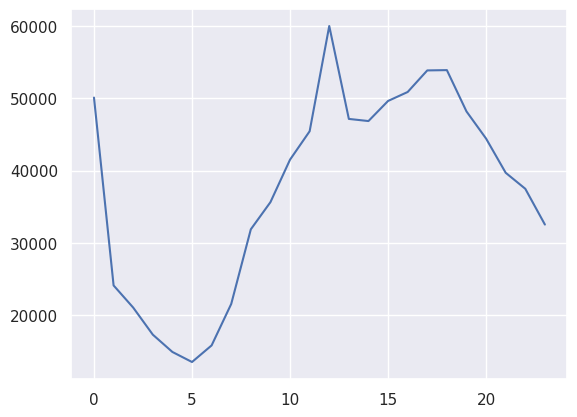

In [ ]:
plt.plot(df_time_incident.Time, df_time_incident.Incidents)
plt.title("Incident levels through the day, raw")
plt.xlabel("Hour of day, 24 hours")
plt.ylabel("Number of incidents")

In [234]:
#Exploration question: does crime occur more in certain days of the week? Plus plot
stage = df.groupby('Day Number')['Incident Datetime'].count()
times = []
for g in stage:
  times.append(g/1000.0)
arr1 = sorted(df['Day Number'].unique())
data1 = {'Day': arr1,
        'Incidents': times}

df_day_incident = pd.DataFrame(data1)

Text(0, 0.5, 'Incidents in the 1000s')

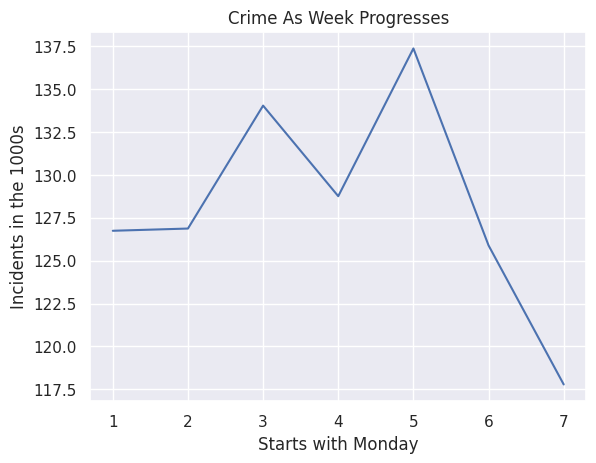

In [237]:
plt.plot(df_day_incident.Day, df_day_incident.Incidents)
plt.title("Crime As Week Progresses")
plt.xlabel("Starts with Monday")
plt.ylabel("Incidents in the 1000s")

In [ ]:
# How many crimes in each category?
df.groupby('Incident Category')['Incident Datetime'].count()

,Incident Datetime
Incident Category,
Arson,2590
Assault,55766
Burglary,49910
Case Closure,3504
Civil Sidewalks,889
Courtesy Report,2751
Disorderly Conduct,15639
Drug Offense,23195
Drug Violation,301


In [159]:
# Any correlations between columns?
df.corr(numeric_only=True)

,level_0,index,Incident Year,Day Number,Minutes Til Report,Incident Time Hour,Latitude,Longitude,Elevation
level_0,1.000000,0.905517,0.566180,0.011590,-0.070919,-0.026462,-0.080170,-0.012648,0.039929
index,0.905517,1.000000,0.732972,0.000056,-0.058657,-0.046484,-0.075439,-0.012956,0.063565
Incident Year,0.566180,0.732972,1.000000,0.015699,-0.309328,0.003908,-0.111887,-0.042922,0.108279
Day Number,0.011590,0.000056,0.015699,1.000000,0.000386,-0.072884,0.070125,0.047971,0.047917
Minutes Til Report,-0.070919,-0.058657,-0.309328,0.000386,1.000000,-0.092445,0.043637,0.050822,-0.051240
Incident Time Hour,-0.026462,-0.046484,0.003908,-0.072884,-0.092445,1.000000,-0.072779,-0.035222,0.036046
Latitude,-0.080170,-0.075439,-0.111887,0.070125,0.043637,-0.072779,1.000000,0.095783,-0.194418
Longitude,-0.012648,-0.012956,-0.042922,0.047971,0.050822,-0.035222,0.095783,1.000000,-0.522049
Elevation,0.039929,0.063565,0.108279,0.047917,-0.051240,0.036046,-0.194418,-0.522049,1.000000


In [ ]:
# Exploration question: any correlations amongst traffic collision incidents?
traffic = df[df['Incident Category']=="Traffic Collision"]
traffic.corr(numeric_only=True)

,Incident Year,Day Number,Minutes Til Report,Incident Time Hour,Latitude,Longitude
Incident Year,1.000000,0.075070,-0.050944,0.000536,0.023605,-0.014941
Day Number,0.075070,1.000000,0.006322,-0.059917,0.012610,-0.001519
Minutes Til Report,-0.050944,0.006322,1.000000,-0.008261,0.007319,-0.013861
Incident Time Hour,0.000536,-0.059917,-0.008261,1.000000,-0.025617,-0.022902
Latitude,0.023605,0.012610,0.007319,-0.025617,1.000000,0.073143
Longitude,-0.014941,-0.001519,-0.013861,-0.022902,0.073143,1.000000


In [148]:
# Exploration question: any correlations in warrant-related incidents?
warr = df[df['Incident Category']=="Warrant"]
warr.corr(numeric_only=True)

,index,Incident Year,Day Number,Minutes Til Report,Incident Time Hour,Latitude,Longitude,Elevation
index,1.000000,-0.726486,-0.095585,0.042621,-0.178076,0.170414,0.084365,NaN
Incident Year,-0.726486,1.000000,0.045766,-0.010255,0.176867,-0.145730,0.046827,NaN
Day Number,-0.095585,0.045766,1.000000,-0.043036,-0.100168,-0.059742,-0.032690,NaN
Minutes Til Report,0.042621,-0.010255,-0.043036,1.000000,-0.004592,0.011241,-0.103872,NaN
Incident Time Hour,-0.178076,0.176867,-0.100168,-0.004592,1.000000,0.134436,0.028401,NaN
Latitude,0.170414,-0.145730,-0.059742,0.011241,0.134436,1.000000,0.515115,NaN
Longitude,0.084365,0.046827,-0.032690,-0.103872,0.028401,0.515115,1.000000,NaN
Elevation,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [150]:
# Exploration question: any correlations within disorderly conduct?
disorder = df[df['Incident Category']=="Disorderly Conduct"]
disorder.corr(numeric_only=True)

(0, 16)


,level_0,index,Incident Year,Day Number,Minutes Til Report,Incident Time Hour,Latitude,Longitude,Elevation
level_0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
index,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Incident Year,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Day Number,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Minutes Til Report,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Incident Time Hour,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Latitude,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Longitude,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Elevation,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Exploration question: any correlations in drug-related incidents?
drug = df[df['Incident Category']=="Drug Offense"]
drug.corr(numeric_only=True)

,Incident Year,Day Number,Reporting Minutes,Incident Minutes,Incident Code,Latitude,Longitude
Incident Year,1.000000,-0.011671,-0.022687,0.063697,0.064490,0.085740,0.082150
Day Number,-0.011671,1.000000,-0.001768,-0.055627,0.012444,-0.024568,-0.013711
Reporting Minutes,-0.022687,-0.001768,1.000000,-0.020981,-0.006209,-0.002536,-0.024416
Incident Minutes,0.063697,-0.055627,-0.020981,1.000000,-0.041256,0.024553,0.008518
Incident Code,0.064490,0.012444,-0.006209,-0.041256,1.000000,-0.040439,0.009719
Latitude,0.085740,-0.024568,-0.002536,0.024553,-0.040439,1.000000,0.177408
Longitude,0.082150,-0.013711,-0.024416,0.008518,0.009719,0.177408,1.000000


In [ ]:
# Clean data further for elevation investigation
#remove NaN from whole df and reset index
df = df[df['Latitude'].notna()]
df = df[df['Longitude'].notna()]
df = df.reset_index()

In [ ]:
# Add data: new empty column for land elevation based on coordinates
df["Elevation"] = np.nan

In [ ]:
# Function for getting elevation from external source
def get_elevation(lat, long):
    # query = f"https://api.opentopodata.org/v1/aster30m?locations={lat},{long}" #this source gives bad data!!
    # re = requests.get(query).json()
    time.sleep(0.5)
    query = ('https://api.open-elevation.com/api/v1/lookup'f'?locations={lat},{long}')
    r = requests.get(query).json()
    e = pd.json_normalize(r, 'results')['elevation'].values[0]
    return e


In [ ]:
# Request elevation data and populate Elevation column
elevations = [] #save externally since API is buggy
for m in range(df['Latitude'].size):
    lat = df['Latitude'][m]
    e = get_elevation(lat, df['Longitude'][m])
    df.loc[m, "Elevation"] = e
    elevations.append(e)
print(elevations)

JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [ ]:
print(len(elevations))

449


In [ ]:
# check out the goods
df.describe()

,index,Incident Year,Day Number,Minutes Til Report,Incident Time Hour,Latitude,Longitude,Elevation
count,848111.000000,848111.000000,848111.000000,8.481110e+05,848111.000000,848111.000000,848111.000000,1003.000000
mean,452774.837214,2020.761096,3.970586,1.384379e+04,12.940757,37.768949,-122.423994,40.358923
std,255466.514886,1.959750,1.970190,9.951784e+04,6.473238,0.024517,0.026338,35.568337
min,9.000000,2018.000000,1.000000,-9.217000e+03,0.000000,37.707988,-122.511940,-3.000000
25%,239078.500000,2019.000000,2.000000,5.000000e+00,9.000000,37.753957,-122.434483,15.000000
50%,457674.000000,2021.000000,4.000000,1.260000e+02,14.000000,37.775714,-122.417716,30.000000
75%,672891.500000,2022.000000,6.000000,1.485000e+03,18.000000,37.785744,-122.407337,57.000000
max,897431.000000,2024.000000,7.000000,3.549427e+06,23.000000,37.829991,-122.363739,223.000000


In [131]:
# Data organizing: new table containing rows that have elevation
df2 = df[df['Elevation'].notna()]

In [132]:
df2=df2.reset_index()

Exploration: There seems to be a correlation between elevation and crime

In [113]:
# Grouping elevation to 10 meter chunks
neg = 0
p10= 0
p20= 0
p30= 0
p40= 0
p50= 0
p60= 0
p70= 0
p80= 0
p90= 0
p100= 0
p110= 0
p120= 0
p130= 0
p140= 0
p150= 0
p160= 0
p170= 0
p180= 0
p190= 0
p200= 0
p210= 0
p220= 0
p230= 0
p240= 0
p250= 0
p260= 0
p270= 0

for e in df2["Elevation"]:
  if e < 0:
    neg += 1
  elif e < 10:
    p10 += 1
  elif e < 20:
    p20 += 1
  elif e < 30:
    p30 += 1
  elif e < 40:
    p40 += 1
  elif e < 50:
    p50 += 1
  elif e < 60:
    p60 += 1
  elif e < 70:
    p70 += 1
  elif e < 80:
    p80 += 1
  elif e < 90:
    p90 += 1
  elif e < 100:
    p100 += 1
  elif e < 110:
    p110 += 1
  elif e < 120:
    p120 += 1
  elif e < 130:
    p130 += 1
  elif e < 140:
    p140 += 1
  elif e < 150:
    p150 += 1
  elif e < 160:
    p160 += 1
  elif e < 170:
    p170 += 1
  elif e < 180:
    p180 += 1
  elif e < 190:
    p190 += 1
  elif e < 200:
    p200 += 1
  elif e < 210:
    p210 += 1
  elif e < 220:
    p220 += 1
  elif e < 230:
    p230 += 1
  elif e < 240:
    p240 += 1
  elif e < 250:
    p250 += 1
  elif e < 260:
    p260 += 1
  else:
    p270 += 1

d = {'Elevation': [0, 10, 20, 30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180,190,200,210,220,230,240,250,260,270],
      'Incidents': [neg, p10,p20,p30,p40,p50,p60,p70,p80,p90,p100,p110,p120,p130,p140,p150,p160,p170,p180,p190,p200,p210,p220,p230,p240,p250,p260,p270]}

# Create df for grouped elevation
df_elevation = pd.DataFrame(d)

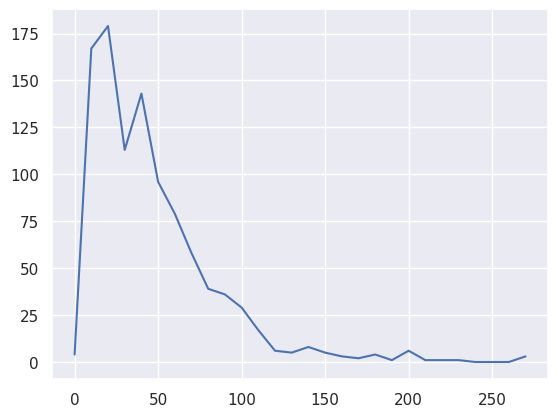

In [119]:
# How many crimes in each elevation level?
# even with a small dataset, there is a pattern than crime decreses with elevation
plt.plot(df_elevation.Elevation, df_elevation.Incidents)

In [212]:
fraud_clean = df2[df2['Incident Category']=="Fraud"] #somewhat small
print(fraud_clean.shape)
fraud_clean.corr(numeric_only=True)

(25, 17)


,level_0,index,Incident Year,Day Number,Minutes Til Report,Incident Time Hour,Latitude,Longitude,Elevation,Elevation Level
level_0,1.000000,0.890831,0.482501,-0.006013,-0.383723,-0.160434,-0.317344,-0.198038,0.114049,0.999676
index,0.890831,1.000000,0.733466,0.116310,-0.407512,-0.194955,-0.252999,-0.217436,0.237357,0.999260
Incident Year,0.482501,0.733466,1.000000,0.181677,-0.616368,-0.164529,-0.241184,-0.287570,0.414775,-0.188982
Day Number,-0.006013,0.116310,0.181677,1.000000,-0.107614,0.088240,-0.083748,0.029734,0.197205,0.981981
Minutes Til Report,-0.383723,-0.407512,-0.616368,-0.107614,1.000000,-0.279922,0.216444,0.199861,-0.083856,0.188089
Incident Time Hour,-0.160434,-0.194955,-0.164529,0.088240,-0.279922,1.000000,0.384660,-0.219985,-0.119917,-0.057639
Latitude,-0.317344,-0.252999,-0.241184,-0.083748,0.216444,0.384660,1.000000,-0.007759,-0.055482,-0.914985
Longitude,-0.198038,-0.217436,-0.287570,0.029734,0.199861,-0.219985,-0.007759,1.000000,-0.393645,0.695365
Elevation,0.114049,0.237357,0.414775,0.197205,-0.083856,-0.119917,-0.055482,-0.393645,1.000000,-0.614132
Elevation Level,0.999676,0.999260,-0.188982,0.981981,0.188089,-0.057639,-0.914985,0.695365,-0.614132,1.000000


In [111]:
assult_clean = df2[df2['Incident Category']=="Assault"] #big enough
print(assult_clean.shape)
assult_clean.corr(numeric_only=True)

(117, 17)


,level_0,index,Incident Year,Day Number,Minutes Til Report,Incident Time Hour,Latitude,Longitude,Elevation,Elevation Level
level_0,1.000000,0.920661,0.738483,-0.102222,-0.036253,-0.041696,-0.090037,-0.039479,0.077670,0.998615
index,0.920661,1.000000,0.794908,-0.074464,0.009598,-0.058762,-0.063927,-0.031157,0.089805,0.994407
Incident Year,0.738483,0.794908,1.000000,-0.052031,-0.254506,-0.074659,-0.136519,-0.043700,0.138706,0.228453
Day Number,-0.102222,-0.074464,-0.052031,1.000000,0.098939,-0.135807,0.202526,-0.018480,0.166554,-0.015547
Minutes Til Report,-0.036253,0.009598,-0.254506,0.098939,1.000000,0.106857,0.088122,-0.040897,-0.020019,-0.041002
Incident Time Hour,-0.041696,-0.058762,-0.074659,-0.135807,0.106857,1.000000,-0.043664,-0.046135,0.085325,-0.267477
Latitude,-0.090037,-0.063927,-0.136519,0.202526,0.088122,-0.043664,1.000000,0.041027,-0.136779,0.214923
Longitude,-0.039479,-0.031157,-0.043700,-0.018480,-0.040897,-0.046135,0.041027,1.000000,-0.386463,0.151766
Elevation,0.077670,0.089805,0.138706,0.166554,-0.020019,0.085325,-0.136779,-0.386463,1.000000,-0.254831
Elevation Level,0.998615,0.994407,0.228453,-0.015547,-0.041002,-0.267477,0.214923,0.151766,-0.254831,1.000000


In [112]:
missing_clean = df2[df2['Incident Category']=="Missing Person"]
print(missing_clean.shape)
missing_clean.corr(numeric_only=True)

(28, 17)


,level_0,index,Incident Year,Day Number,Minutes Til Report,Incident Time Hour,Latitude,Longitude,Elevation,Elevation Level
level_0,1.000000,0.872609,0.586194,0.197037,0.349918,0.104605,-0.163701,-0.098203,0.118730,0.997938
index,0.872609,1.000000,0.783046,0.120440,0.274837,0.049776,-0.076287,-0.137993,0.150445,0.997177
Incident Year,0.586194,0.783046,1.000000,0.049284,0.193285,0.084686,-0.062296,-0.066382,0.073982,0.277055
Day Number,0.197037,0.120440,0.049284,1.000000,0.252692,0.226941,-0.080350,-0.057110,-0.126721,0.152184
Minutes Til Report,0.349918,0.274837,0.193285,0.252692,1.000000,0.143341,-0.337889,-0.219397,0.430507,0.515888
Incident Time Hour,0.104605,0.049776,0.084686,0.226941,0.143341,1.000000,-0.283902,-0.270670,0.316240,-0.470646
Latitude,-0.163701,-0.076287,-0.062296,-0.080350,-0.337889,-0.283902,1.000000,0.056651,-0.044182,0.738625
Longitude,-0.098203,-0.137993,-0.066382,-0.057110,-0.219397,-0.270670,0.056651,1.000000,-0.678437,0.069364
Elevation,0.118730,0.150445,0.073982,-0.126721,0.430507,0.316240,-0.044182,-0.678437,1.000000,-0.155648
Elevation Level,0.997938,0.997177,0.277055,0.152184,0.515888,-0.470646,0.738625,0.069364,-0.155648,1.000000


###Step 3: Model analysis: building and training the model

a. Multi Regression for the many features

b. Building off of the most promising correlations discovered during exploration

In [205]:
#split the data into training and testing
trainset, testset = train_test_split(df2, test_size=0.25)

In [240]:
# make col names more usable
df2.rename(columns={'Incident Year': 'year', 'Day Number': 'day', 'Minutes Til Report': 'minutes', 'Incident Time Hour': 'hour'}, inplace=True)

In [206]:
# Model #1: Time to Report

# multi regression

# Goal: predicts how long it takes to file a report, knowing the
# day of week, time, and elevation at which crime occurred

model_df2 = smf.ols(formula="minutes ~ year+day+hour+Elevation", data=trainset)
fitted = model_df2.fit()
fitted.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                minutes   R-squared:                       0.106
Model:                            OLS   Adj. R-squared:                  0.102
Method:                 Least Squares   F-statistic:                     22.23
Date:                Tue, 15 Oct 2024   Prob (F-statistic):           2.33e-17
Time:                        20:11:27   Log-Likelihood:                -9879.9
No. Observations:                 752   AIC:                         1.977e+04
Df Residuals:                     747   BIC:                         1.979e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.122e+08   1.26e+07      8.876      0.000    8.74e+07    1.37e+08
year       -5.544e+04   6248.633     -8.872      0.000   -6.77e+04   -4.32e+04
day         1438.3338   2870.905      0.501      0.617   -4197.668    7074.335
hour       -1598.1743    666.393     -2.398      0.017   -2906.400    -289.948
Elevation    -97.1477    127.260     -0.763      0.445    -346.978     152.682
==============================================================================
Omnibus:                     1340.444   Durbin-Watson:                   1.943
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1007121.850
Skew:                          11.740   Prob(JB):                         0.00
Kurtosis:                     180.738   Cond. No.                     5.68e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.68e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [222]:
# Model #2: Assult reporting

# multi regression

# Goal: predicts how long it takes to file an assult crime report,
# given the time and elevation at which crime occurred

assult_clean.rename(columns={'Incident Year': 'year', 'Day Number': 'day', 'Minutes Til Report': 'minutes', 'Incident Time Hour': 'hour'}, inplace=True)
m_assult_clean = smf.ols(formula="minutes ~ Elevation+hour", data=assult_clean) #shoved entire dataset, small
fitted_assult_clean = m_assult_clean.fit()
fitted_assult_clean.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                minutes   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                 -0.005
Method:                 Least Squares   F-statistic:                    0.7083
Date:                Tue, 15 Oct 2024   Prob (F-statistic):              0.495
Time:                        20:27:15   Log-Likelihood:                -1567.9
No. Observations:                 117   AIC:                             3142.
Df Residuals:                     114   BIC:                             3150.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1701.5467   3.53e+04      0.048      0.962   -6.83e+04    7.17e+04
Elevation   -173.2881    551.585     -0.314      0.754   -1265.974     919.398
hour        2410.1599   2058.906      1.171      0.244   -1668.517    6488.837
==============================================================================
Omnibus:                      213.366   Durbin-Watson:                   2.080
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            24426.218
Skew:                           7.893   Prob(JB):                         0.00
Kurtosis:                      72.002   Cond. No.                         109.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [223]:
# Model #2: Elevation prediction

# multi regression (not a simple line)

# Goal: predicts how much relative crime to expect at given elevation

m_elevation = smf.ols(formula="Incidents ~ Elevation", data=df_elevation)
fitted_elevation = m_elevation.fit()
fitted_elevation.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Incidents   R-squared:                       0.543
Model:                            OLS   Adj. R-squared:                  0.525
Method:                 Least Squares   F-statistic:                     30.87
Date:                Tue, 15 Oct 2024   Prob (F-statistic):           7.80e-06
Time:                        20:33:02   Log-Likelihood:                -140.18
No. Observations:                  28   AIC:                             284.4
Df Residuals:                      26   BIC:                             287.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    101.7512     13.806      7.370      0.000      73.373     130.130
Elevation     -0.4876      0.088     -5.556      0.000      -0.668      -0.307
==============================================================================
Omnibus:                        2.709   Durbin-Watson:                   0.993
Prob(Omnibus):                  0.258   Jarque-Bera (JB):                1.435
Skew:                           0.136   Prob(JB):                        0.488
Kurtosis:                       4.075   Cond. No.                         306.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

###Step 4: Results

Model #1: Despite more promising results from the correlation matrix, there doesn't seem to be a meaningful correlation between time it takes to report and the day, time, and elevation. With an R-squared result of 0.106, it's not hopeless. Next steps would be remove features with highest p-values.

Model #2: This is an example of a non-correlation. R-squared is very low (0.012), the R-adjusted is negative, and p-values indicate that this is no better than random chance. This lead should be dropped.

Model #3: With an adjusted R-squared of 0.525 (low number of samples so using adjusted R instead), and favorable p-value and F-statistic, this is the winner of the bunch. There seems to be a correlation between crime incidents and elevation.

###Step 5:  Discussion and conclusion

Multi regression was chosen to try to use all the features. I learned that it is not always good to try to use all features. Instead, focus on just the most promising ones.

Some of the datasets ended up small so I resorted to training using the whole dataset. With more effort, more real data can be harvested from the master SFPD dataset.

Conclusions:

1) Free and unmaintained data is dirty - you're paying with your time to clean it.

2) Raw data is hides insights. Crime does not have very obvious patterns; if it did then it would be better controlled. Interesting and novel insights, however, can still be found so it is worth it to continue analyzing.